In [92]:
from utils import sars2_genome_info, get_parent, add_syn_mut_attribute, add_mut_at_node_attr 
from utils_randomization import get_total_muts_on_tree, get_branch_lengths, randomize_mutations_on_tree_multinomial
from utils_randomization import random_wait_times, s1_wait_times, rdrp_wait_times
from utils_plotting import get_color_palette, convert_linege_names, get_linear_reg_stats
from augur.utils import json_to_tree
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy import stats
import numpy as np
import pandas as pd
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.Seq import MutableSeq
from collections import Counter
from scipy import stats
import requests
import random
import math
import json

## Figure 3: S1 substitutions are temporally clustered

##### Wait times between mutations are measured to show that S1 mutations cluster temporally.

##### A p-value is assigned to the difference between observed and expected wait times from 1000 randomized trees.

#### This notebook completes the analysis for Figure 3 B and C and Figure 3 supplement 2. 

Import the tree and convert to Bio Phylo format. This is a time-resolved phylogeny built from 9544 SARS-CoV-2 genomes sampled between December 2019 and May 15, 2021. The tree can be viewed at https://nextstrain.org/groups/blab/ncov/adaptive-evolution/2021-05-15

In [2]:
tree_url = 'https://nextstrain-blab.s3.amazonaws.com/ncov_adaptive-evolution_2021-05-15.json'

tree_json = requests.get(tree_url).json()

#Put tree in Bio.Phylo format
tree = json_to_tree(tree_json)

Add information about synonymous mutations as an attribute of nodes on the tree

In [3]:
tree = add_syn_mut_attribute(tree)

Add the number of mutations that occur at a node as an attribute of that node, for all nodes on the tree

In [4]:
tree = add_mut_at_node_attr(tree)

Find the total number of mutations that occur within each gene on internal branches of the tree

In [5]:
total_mutations_nonsyn, total_mutations_syn = get_total_muts_on_tree(tree)

Find the length of every branch

In [6]:
branch_names_all, branch_lengths_all = get_branch_lengths(tree)

Find the wait times between S1 (or RdRp) mutations on empirical and randomized trees. Wait times are calculated between a mutation and the next mutation along each descending path. 

This function randomizes mutations across the tree then calculates wait times between those randomized mutations. It also calculates empirical wait times. A total of 1000 iterations have already been run and wait times from each iteration are saved in a .json file in the "wait_time_stats/" directory. Because randomizations are time-consuming, they were run in chunks and stored in several files

In [7]:
def wait_time_stats(tree, genes, iterations, save_filename):
    
    wait_times_stats_dict = {'wait_times_stats':[]}
    
    for gene in genes:
        if gene == 'S1':
            nonsyn_syn_options=['nonsyn', 'syn']
        else:
            nonsyn_syn_options=['nonsyn']
        
        for nonsyn_syn in nonsyn_syn_options:
            # at each iteration, randomize the tree and calculate wait times
            for x in range(iterations):
                
                # randomize mutation positions on tree
                if nonsyn_syn == 'nonsyn':
                    tree = randomize_mutations_on_tree_multinomial(tree, total_mutations_nonsyn[gene], 
                                                                   branch_lengths_all, branch_names_all)
                elif nonsyn_syn == 'syn':
                    tree = randomize_mutations_on_tree_multinomial(tree, total_mutations_syn[gene], 
                                                                   branch_lengths_all, branch_names_all)
                    
                wait_times_random = random_wait_times(tree)
                
                mean_wait_time_random = sum(wait_times_random)/len(wait_times_random)
                
                under_02_random = len([x for x in wait_times_random if x<=0.2])/len(wait_times_random)
                under_04_random = len([x for x in wait_times_random if x<=0.4])/len(wait_times_random)
                under_06_random = len([x for x in wait_times_random if x<=0.6])/len(wait_times_random)
                
                # store mean wait time per randomization iteration. Also proportion under 0.2, 0.4, 0.6 years
                wait_times_stats_dict['wait_times_stats'].append({'data': 'expected', 'gene': gene, 'nonsyn_syn': nonsyn_syn,
                                                        'wait_times': wait_times_random,
                                                        'mean_wait_time': mean_wait_time_random, 
                                                        'proportion_under_02': under_02_random, 
                                                        'proportion_under_04': under_04_random, 
                                                        'proportion_under_06': under_06_random})


            
            # find these values for empirical data too 
            # do multiple iterations as well because date of mutation is picked randomly along branch length
            for x in range(iterations):
                if gene == 'S1':
                    all_wait_times_s1 = s1_wait_times(tree,nonsyn_syn)
                    wait_times_empirical = all_wait_times_s1
                elif gene == 'RdRp':
                    all_wait_times_rdrp = rdrp_wait_times(tree)
                    wait_times_empirical = all_wait_times_rdrp
                    
                mean_wait_time_empirical = sum(wait_times_empirical)/len(wait_times_empirical)
                
                under_02_empirical = len([x for x in wait_times_empirical if x<=0.2])/len(wait_times_empirical)
                under_04_empirical = len([x for x in wait_times_empirical if x<=0.4])/len(wait_times_empirical)
                under_06_empirical = len([x for x in wait_times_empirical if x<=0.6])/len(wait_times_empirical)
                
                # store mean wait time per  iteration. Also proportion under 0.2, 0.4, 0.6 years
                wait_times_stats_dict['wait_times_stats'].append({'data': 'observed', 'gene': gene, 'nonsyn_syn': nonsyn_syn,
                                                        'wait_times': wait_times_empirical,
                                                        'mean_wait_time': mean_wait_time_empirical, 
                                                        'proportion_under_02': under_02_empirical, 
                                                        'proportion_under_04': under_04_empirical, 
                                                        'proportion_under_06': under_06_empirical})

    with open(save_filename, 'w') as outfile:
        json.dump(wait_times_stats_dict, outfile)

    

In [ ]:
# wait_time_stats(['s1', 'rdrp'], 250, 'wait_time_stats/wait_time_stats_250more_internal.json')

For 1000 iterations, plot the distribution of observed and expected wait times. Make separate subplots for S1 nonsynonymous, S1 synonymous and RdRp nonsynonymous wait times.

This function generates Figure 3B.

In [15]:
def plot_fig3b(data_files, filename=None):
    """
    Reads in data files containing wait times from all iterations. Plots a 
    histogram comparing expected and observed wait times between S1 
    nonsynonymous, S1 synonymous and RdRp nonsynonymous mutations
    """

    # dataframe for all wait time information, 
    # each row is an iteration for expected or observed, s1 or rdrp, syn or nonsyn
    to_plot = pd.DataFrame(columns = ['data', 'gene', 'nonsyn_syn',
                                         'wait_times', 'mean_wait_time', 
                                         'proportion_under_02', 'proportion_under_04',
                                         'proportion_under_06', 'proportion_under_08'])
    
    for data_file in data_files:
        with open(data_file) as json_file:
            data = json.load(json_file)
            df = pd.DataFrame(data['wait_times_stats'])
            to_plot = pd.concat([to_plot, df])

    
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,4), sharey=True)
    plt.tight_layout()
    sns.set_style("white")
    

    cmap1 = {'expected':"#ABABAB",'observed':"#4770eb"}
    cmap2 = {'expected':"#ABABAB",'observed':"#5094e3"}
    cmap3 = {'expected':"#ABABAB",'observed':"#ff8c3a"}
    
    to_plot = to_plot.explode('wait_times').reset_index()

    
    ax1 = sns.histplot(data=to_plot[(to_plot['gene']=='s1') & (to_plot['nonsyn_syn']=='nonsyn')], 
                       x='wait_times', hue='data', 
                      palette = cmap1, hue_order=['expected','observed'],
                      element = 'step',
                      bins=20, 
                      common_norm = False, stat='probability', ax=ax1)
    ax1.legend(handles=ax1.legend_.legendHandles, labels=[t.get_text() for t in ax1.legend_.texts],
              title='',
              bbox_to_anchor=(0.65, 0.95), loc='upper left', fontsize=12)
    
    ax2 = sns.histplot(data=to_plot[(to_plot['gene']=='s1') & (to_plot['nonsyn_syn']=='syn')], 
                       x='wait_times', hue='data', 
                      palette = cmap2, hue_order=['expected','observed'],
                      element = 'step',
                      bins=20, 
                      common_norm = False, stat='probability', ax=ax2)
    ax2.legend(handles=ax2.legend_.legendHandles, labels=[t.get_text() for t in ax2.legend_.texts],
              title='',
              bbox_to_anchor=(0.65, 0.95), loc='upper left', fontsize=12)
    
    ax3 = sns.histplot(data=to_plot[(to_plot['gene']=='rdrp') & (to_plot['nonsyn_syn']=='nonsyn')], 
                       x='wait_times', hue='data', 
                      palette = cmap3, hue_order=['expected','observed'],
                      element = 'step',
                      bins=20, 
                      common_norm = False, stat='probability', ax=ax3)
    ax3.legend(handles=ax3.legend_.legendHandles, labels=[t.get_text() for t in ax3.legend_.texts],
              title='',
              bbox_to_anchor=(0.65, 0.95), loc='upper left', fontsize=12)



    ax1.set_title(f'S1 nonsynonymous', fontsize = 18)
    ax2.set_title(f'S1 synonymous', fontsize = 18)
    ax3.set_title(f'RdRp nonsynonymous', fontsize = 18)
    
    ax1.set_xlabel('wait time', fontsize=16)
    ax2.set_xlabel('wait time', fontsize=16)
    ax3.set_xlabel('wait time', fontsize=16)
    
    for ax in [ax1, ax2, ax3]:
        ax.set_ylabel('probability', fontsize = 16)
        ax.tick_params(axis='both', which='major', labelsize=12)
    
    
    sns.despine(left=False, bottom=False)
    plt.subplots_adjust(wspace=0.1)
    
    plt.figtext(-0.02, 0.96, 'B', fontsize=24, fontweight='bold')

    if filename:
        fig.savefig(filename, dpi=300, bbox_inches='tight')
    
    

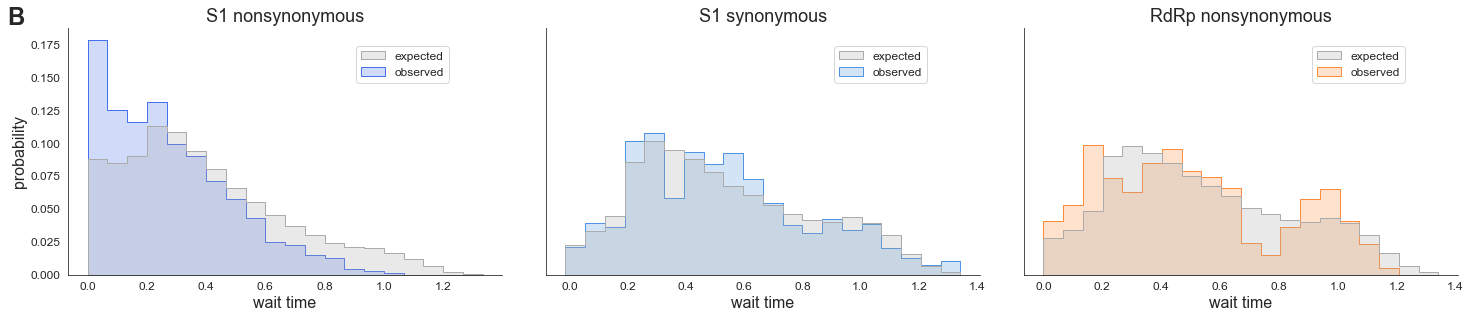

In [17]:
plot_fig3b(['wait_time_stats/wait_time_stats_50_internal.json', 
            'wait_time_stats/wait_time_stats_50more_internal.json', 
            'wait_time_stats/wait_time_stats_200_internal.json', 
            'wait_time_stats/wait_time_stats_200more_internal.json', 
            'wait_time_stats/wait_time_stats_250_internal.json', 
            'wait_time_stats/wait_time_stats_250more_internal.json'], filename = 'plots/fig3b_20210515.png')

There appear to be an excess of short S1 nonsynonymous wait times. To test this, find the mean wait times and the proportion of expected and observed wait times shorter than 0.3 years for each category of mutations.

The following function plots Figure 3C i and ii.

In [90]:
def plot_wait_time_stats(data_files, filename=None):
    """
    Reads in all wait time data files and plots the empirical 
    mean wait time against the distribution of expected mean wait 
    times from 1000 randomized trees. Also plots the proportion 
    of empirical wait times that are under 0.3 years versus the 
    distribution of expected wait times under 0.3 years 
    """
    
    # dataframe for all wait time information, 
    # each row is an iteration for expected or observed, s1 or rdrp, syn or nonsyn
    to_plot_df = pd.DataFrame(columns = ['data', 'gene', 'nonsyn_syn',
                                         'wait_times', 'mean_wait_time', 
                                         'proportion_under_02', 'proportion_under_04',
                                         'proportion_under_06', 'proportion_under_08'])
    
    for data_file in data_files:
        with open(data_file) as json_file:
            data = json.load(json_file)
            df = pd.DataFrame(data['wait_times_stats'])
            to_plot_df = pd.concat([to_plot_df, df])
    
    # find the proportion of wait times under 0.3 years
    proportion_under_03 = []
    for k,v in to_plot_df.iterrows():
        proportion_under_03.append(len([x for x in v.wait_times if x<=0.3])/len([x for x in v.wait_times]))
    to_plot_df['proportion_under_03'] = proportion_under_03  

            
    num_iterations = len(to_plot_df)/6
    

    # initialize the figure
    f = plt.figure(figsize=(20,4))
    sns.set_style("white")
    
    # use gridspec to allow the subplots to have different heights
    gs = gridspec.GridSpec(2, 3, height_ratios=[2.5,1])

    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1], sharey=ax1, sharex=ax1)
    ax3 = plt.subplot(gs[2], sharey=ax1, sharex=ax1) 
    
    ax4 = plt.subplot(gs[3], sharey=ax1) 
    ax5 = plt.subplot(gs[4], sharey=ax1, sharex=ax4) 
    ax6 = plt.subplot(gs[5], sharey=ax1, sharex=ax4)
    
    # list of tuples for plotting: (gene, nonsyn/syn, axes, color, annotation pos, gene name)
    plotting_categories = [('s1', 'nonsyn', (ax1, ax4), "#4770eb", (0.08, 0.67), 'S1'), 
                           ('s1', 'syn', (ax2, ax5), "#5094e3", (0.7, 0.4), 'S1'), 
                           ('rdrp', 'nonsyn', (ax3, ax6), "#ff8c3a", (0.36, 0.42), 'RdRp')]
    
    for c in plotting_categories:
        # subset the plotting dataframe to only one gene and mutation type
        observed_subset = to_plot_df[(to_plot_df['gene']==c[0]) & (to_plot_df['nonsyn_syn']==c[1]
                                                            ) & (to_plot_df['data']=='observed')]
        expected_subset = to_plot_df[(to_plot_df['gene']==c[0]) & (to_plot_df['nonsyn_syn']==c[1]
                                                            ) & (to_plot_df['data']=='expected')]
        # on upper row of axes, plot distribution of expected mean wait times  
        sns.histplot(data=expected_subset, 
                       x='mean_wait_time', color = "#ABABAB",
                      element = 'step',alpha=0.25,
                      bins=10, stat='count', ax=c[2][0])
        observed_mean = observed_subset['mean_wait_time'].mean()
        # add a colored vertical line showing the observed mean
        c[2][0].axvline(x=observed_mean, color = c[3], linewidth=4)
        # find p-value for mean wait time
        p_value_mean = len(expected_subset[expected_subset['mean_wait_time']<observed_mean])/num_iterations
        # make p-value more legible for figure by rounding
        if p_value_mean<=0.001:
            p_value_mean = '< 0.001'
        else:
            p_value_mean = round(p_value_mean,2)
        # add p-value to plot
        c[2][0].annotate(f'p-value: {p_value_mean}', xy=((c[4][0]), 0.90),xycoords='axes fraction',
                         ha='left', size=12, fontweight='bold')
        c[2][0].set_title(f'{c[5]} {c[1]}onymous', fontsize = 18)
        c[2][0].set_xlabel('mean wait time', fontsize=14)
        
        # on lower row of axes, plot distribution of expected proportion of wait times under 0.3 years 
        sns.histplot(data=expected_subset, 
                           x='proportion_under_03', color = "#ABABAB",
                          element = 'step',alpha=0.25,
                          bins=10, stat='count', ax=c[2][1])
        observed_under03 = observed_subset['proportion_under_03'].mean()
        # add a colored vertical line showing the observed proportion under 0.3 years
        c[2][1].axvline(x=observed_under03, color = "#4770eb", linewidth=4)
        # find p-value for proportion of wait times under 0.3 years
        p_value_03 = len(expected_subset[expected_subset['proportion_under_03']>observed_under03])/num_iterations
        if p_value_03<=0.001:
            p_value_03 = '< 0.001'
        else:
            p_value_03 = round(p_value_03,2)
        c[2][1].annotate(f'p-value: {p_value_03}', xy=((c[4][1]), 0.90),
                      xycoords='axes fraction', ha='left', size=12, fontweight='bold')
        c[2][1].set_xlabel('proportion of wait times under 0.3 years', fontsize=14)



    for ax in [ax1,ax2, ax3, ax4, ax5, ax6]:
        ax.set_ylabel('')
        plt.setp(ax.get_yticklabels(), visible=False)
    
    
    sns.despine(left=False, bottom=False)
    plt.subplots_adjust(hspace=0.8, wspace=0.1)
    
    plt.figtext(0.09, 0.9, 'C', fontsize=24, fontweight='bold')
    
    plt.figtext(0.115, 0.86, 'i', fontsize=18, fontweight='bold')
    plt.figtext(0.115, 0.30, 'ii', fontsize=18, fontweight='bold')


    if filename:
        f.savefig(filename, dpi=300, bbox_inches='tight')
    

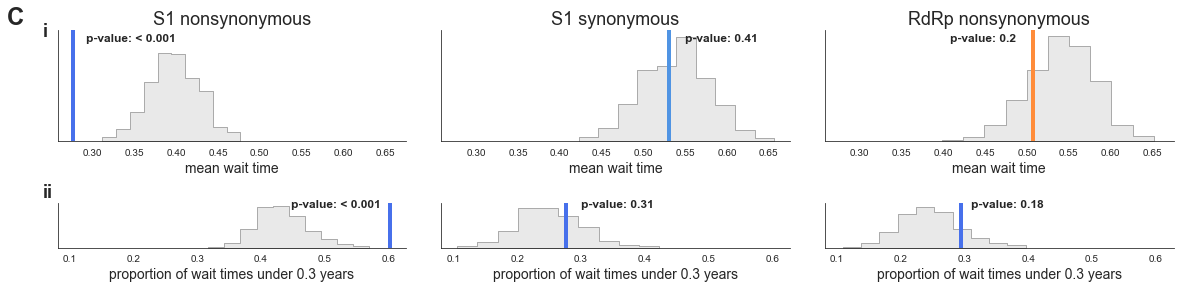

In [91]:
plot_wait_time_stats(['wait_time_stats/wait_time_stats_50_internal.json', 
                      'wait_time_stats/wait_time_stats_50more_internal.json', 
                      'wait_time_stats/wait_time_stats_200_internal.json', 
                      'wait_time_stats/wait_time_stats_200more_internal.json', 
                      'wait_time_stats/wait_time_stats_250_internal.json', 
                      'wait_time_stats/wait_time_stats_250more_internal.json'], filename = 'plots/fig3c_20210515.png')

The shape of the expected wait time distibution depends on the total number of mutations. Demonstrate this by plotting wait time distributions for randomized trees with varying numbers of mutations

This produces Figure 3 Supplement 2

In [24]:
def test_expectation(iterations, test_nums, filename=None):
    
    dfs_to_plot = []
    for y in test_nums:
        wait_times_random = []
        for x in range(iterations):
            randomize_mutations_on_tree_multinomial(tree, y, branch_lengths_all, branch_names_all)
            all_wait_times_random = random_wait_times(tree)
            wait_times_random+=all_wait_times_random


        to_plot_random = pd.DataFrame(wait_times_random, columns=['wait_times'])
        to_plot_random['num_muts'] = y
        
        dfs_to_plot.append(to_plot_random)
        
    to_plot = pd.concat(dfs_to_plot, ignore_index=True)

    
    plt.figure(figsize=(12, 12))
    sns.set_style('white')

    g = sns.FacetGrid(data=to_plot, col = 'num_muts', col_wrap =3,height=2, aspect=1.5,
                      sharex=True, sharey=True)

    
    g.map(sns.histplot, 'wait_times', 
          element = 'step', bins=20, color="#ABABAB", alpha=0.25,
          common_norm = False, stat='probability')

    g.set_axis_labels("wait time", "probability")
    g.set_titles('{col_name} mutations', fontsize=24)
    
    sns.despine(left=False, bottom=False)
    
    if filename:
        g.savefig(filename, dpi=300, bbox_inches='tight')

<Figure size 864x864 with 0 Axes>

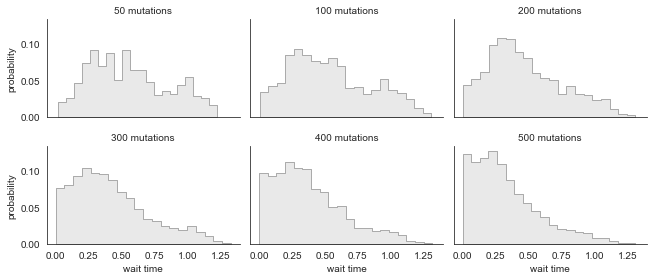

In [80]:
test_expectation(10, [50, 100, 200, 300, 400,500],  filename = 'plots/fig3_supp_20210515.png')